In [1]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the SQL magic extension
%reload_ext sql
# Set display limit
%config SqlMagic.displaylimit = 20

Found pyproject.toml from 'C:\Users\magsa\Desktop\365_Data_Sience\Project\Movie recommendation system\mini-projects\movie-rec-system'

Settings changed:

Config,value
autopandas,True
feedback,True
displaycon,False
named_parameters,True


In [4]:
# Connect to the DuckDB
%sql duckdb:///movies_data.duckdb

In [5]:
%%sql
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'movies';


,column_name,data_type
0,adult,BOOLEAN
1,backdrop_path,VARCHAR
2,genre_ids,BIGINT[]
3,id,BIGINT
4,original_language,VARCHAR
5,original_title,VARCHAR
6,overview,VARCHAR
7,popularity,DOUBLE
8,poster_path,VARCHAR
9,release_date,DATE


In [6]:
%%sql
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'genres';

,column_name,data_type
0,id,BIGINT
1,name,VARCHAR


In [7]:
%%sql
-- # Change the data type from BIGINT to INT
ALTER TABLE movies ALTER COLUMN id TYPE INT;
ALTER TABLE movies ALTER COLUMN vote_count TYPE INT;
ALTER TABLE movies ALTER COLUMN genre_ids TYPE INT[];
ALTER TABLE genres ALTER COLUMN id TYPE INT;

,Success


In [8]:
%%sql
-- # Drop columns ending with _path
ALTER TABLE movies DROP COLUMN backdrop_path;
ALTER TABLE movies DROP COLUMN poster_path;

,Success


In [9]:
%%sql 
SELECT *
FROM movies
LIMIT 2;

,adult,genre_ids,id,original_language,original_title,overview,popularity,release_date,title,video,vote_average,vote_count
0,False,"[27, 53]",1008042,en,Talk to Me,When a group of friends discover how to conjur...,2292.177,2023-07-26,Talk to Me,False,7.3,686
1,False,"[28, 80, 53]",385687,en,Fast X,Over many missions and against impossible odds...,1973.052,2023-05-17,Fast X,False,7.3,3749


In [10]:
%%sql 
SELECT *
FROM genres
LIMIT 2;

,id,name
0,28,Action
1,12,Adventure


In [11]:
%%sql 
WITH ExpandedGenres AS (
    SELECT 
        m.id AS movie_id,
        mg.movie_genre_id,
        g.name AS genre_name
    FROM 
        (SELECT UNNEST(movies.genre_ids) as movie_genre_id, movies.id FROM movies) AS mg
    JOIN 
        movies m ON mg.id = m.id
    JOIN 
        genres g ON mg.movie_genre_id = g.id
)

SELECT
    movie_id,
    STRING_AGG(genre_name, ', ') AS genre_names
FROM 
    ExpandedGenres
GROUP BY 
    movie_id;

,movie_id,genre_names
0,1008042,"Horror, Thriller"
1,385687,"Action, Crime, Thriller"
2,346698,"Comedy, Adventure, Fantasy"
3,615656,"Action, Science Fiction, Horror"
4,968051,"Horror, Mystery, Thriller"
...,...,...
993,257344,"Action, Comedy, Science Fiction"
994,1003581,"Animation, Action, Science Fiction, Adventure"
995,10195,"Adventure, Fantasy, Action"
996,59440,"Drama, Action"


In [24]:
%%sql --no-execute
CREATE TABLE IF NOT EXISTS movie_genre_data AS
WITH ExpandedGenres AS (
    SELECT 
        m.id AS movie_id,
        mg.movie_genre_id,
        g.name AS genre_name
    FROM 
        (SELECT UNNEST(movies.genre_ids) as movie_genre_id, movies.id FROM movies) AS mg
    JOIN 
        movies m ON mg.id = m.id
    JOIN 
        genres g ON mg.movie_genre_id = g.id
),
genre_names AS (
    SELECT
    movie_id,
    STRING_AGG(genre_name, ', ') AS genre_names
FROM 
    ExpandedGenres
GROUP BY 
    movie_id
)
SELECT gn.genre_names, m.id, m.original_language,
       m.overview, m.popularity, m.release_date,
       m.title, m.vote_average, m.vote_count
FROM genre_names gn
JOIN movies m
ON gn.movie_id = m.id
WHERE m.vote_count != 0

Skipping execution...

In [25]:
%%sql
SELECT *
FROM movie_genre_data
LIMIT 2;

,genre_names,id,original_language,overview,popularity,release_date,title,vote_average,vote_count
0,"Horror, Thriller",1008042,en,When a group of friends discover how to conjur...,2292.177,2023-07-26,Talk to Me,7.3,686
1,"Action, Crime, Thriller",385687,en,Over many missions and against impossible odds...,1973.052,2023-05-17,Fast X,7.3,3749


### What are the most popular genres? 

In [14]:
%%sql --save genre_pop --no-execute
WITH ExpandedGenres AS (
    SELECT 
        m.id AS movie_id,
        mg.movie_genre_id,
        g.name AS genre_name
    FROM 
        (SELECT UNNEST(movies.genre_ids) as movie_genre_id, movies.id FROM movies) AS mg
    JOIN 
        movies m ON mg.id = m.id
    JOIN 
        genres g ON mg.movie_genre_id = g.id
)
SELECT
genre_name, 
SUM(m.popularity) AS genre_popularity
FROM ExpandedGenres
JOIN movies m
ON ExpandedGenres.movie_id = m.id
GROUP BY genre_name
ORDER BY genre_popularity DESC;


Skipping execution...

Removing NULLs, if there exists any from genre_name and genre_popularity

<AxesSubplot: title={'center': 'genre_pop'}, xlabel='genre_popularity', ylabel='genre_name'>

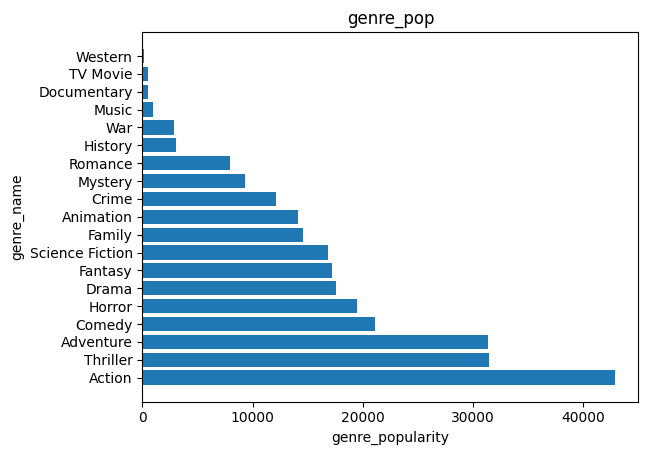

In [15]:
%sqlplot bar --table genre_pop --column genre_name genre_popularity --orient h

### What are the most popular movies?

In [16]:
%%sql --save top10 --no-execute
SELECT title, popularity
FROM movies
ORDER BY popularity DESC
LIMIT 10;

Skipping execution...

Removing NULLs, if there exists any from title and popularity

<AxesSubplot: title={'center': 'top10'}, xlabel='popularity', ylabel='title'>

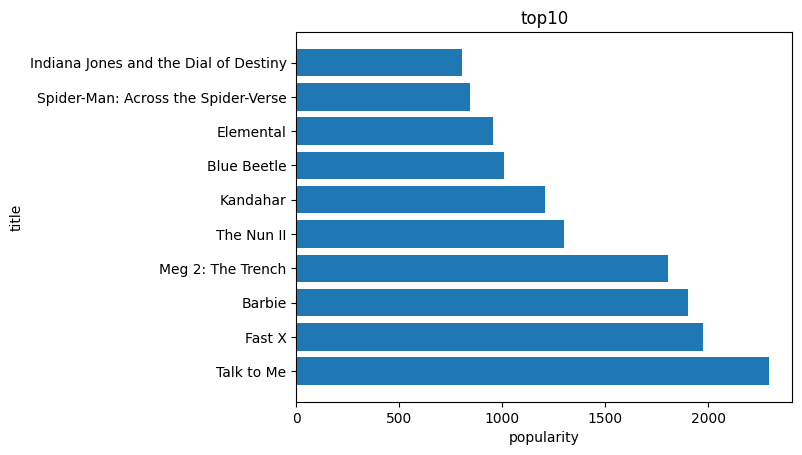

In [17]:
%sqlplot bar --table top10 --column title popularity --orient h

### What are the most popular movies by genre?

In [18]:
%%sql --save top10_genre --no-execute
WITH ExpandedGenres AS (
    SELECT 
        m.id AS movie_id,
        mg.movie_genre_id,
        g.name AS genre_name
    FROM 
        (SELECT UNNEST(movies.genre_ids) as movie_genre_id, movies.id FROM movies) AS mg
    JOIN 
        movies m ON mg.id = m.id
    JOIN 
        genres g ON mg.movie_genre_id = g.id
),
RankedMovies AS (
    SELECT 
        m.title,
        eg.genre_name,
        m.popularity,
        ROW_NUMBER() OVER (PARTITION BY eg.genre_name ORDER BY m.popularity DESC) AS rn
    FROM movies m
    JOIN ExpandedGenres eg ON m.id = eg.movie_id
)
SELECT 
    title, 
    genre_name, 
    popularity
FROM RankedMovies
WHERE rn = 1
ORDER BY popularity DESC
LIMIT 10;


Skipping execution...

Generating CTE with stored snippets: 'top10_genre'

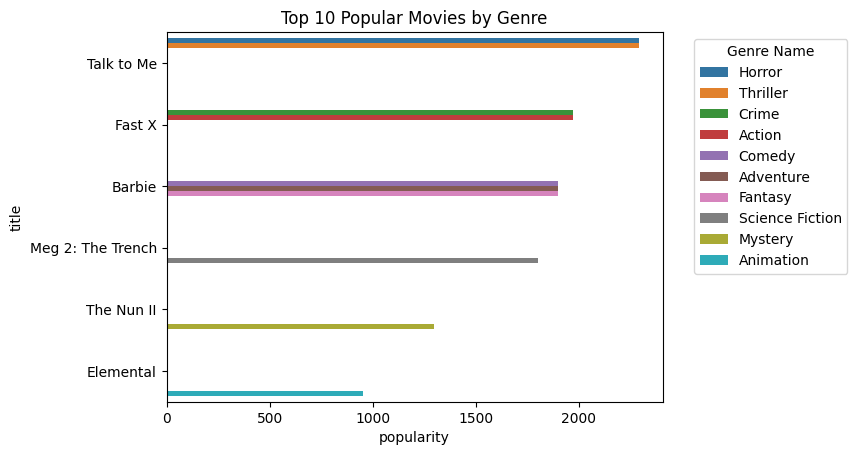

In [19]:
result = %sql SELECT * FROM top10_genre
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming top10_genre is the DataFrame saved from your SQL query
sns.barplot(data=result, x='popularity', y='title', hue='genre_name', orient='h')
plt.title('Top 10 Popular Movies by Genre')
plt.legend(title='Genre Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

 ### What are the most popular movies by decade?

In [20]:
%%sql --save top_decade --no-execute
WITH RankedMovies AS (
    SELECT 
        FLOOR(YEAR(release_date) / 10) * 10 AS decade,
        title,
        popularity,
        RANK() OVER (PARTITION BY FLOOR(YEAR(release_date) / 10) * 10 ORDER BY popularity DESC) AS rank_in_decade
    FROM movie_genre_data
)
SELECT 
    decade,
    title,
    popularity,
    rank_in_decade
FROM RankedMovies
WHERE rank_in_decade <= 2  -- adjust this to get the top N movies in each decade
ORDER BY decade, rank_in_decade;



Skipping execution...

In [21]:
result = %sql SELECT * FROM top_decade
import seaborn as sns
import matplotlib.pyplot as plt

# let us plot the top 2 movies in each decade by popularity putting them side by side in a bar chart, with no hue
plt.figure(figsize=(15, 8))
sns.barplot(data=result, x='decade', y='popularity',hue='title', orient='v')
plt.yscale('log')  # log scale for better visualization
plt.title('Top 2 Movies in Each Decade by Popularity')
plt.legend(title='Movie Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Generating CTE with stored snippets: 'top_decade'

TableNotFoundError: If using snippets, you may pass the --with argument explicitly.
For more details please refer: https://jupysql.ploomber.io/en/latest/compose.html#with-argument

There is no table with name 'top_decade'.
Did you mean: 'top_decade'


Original error message from DB driver:
(duckdb.CatalogException) Catalog Error: Table with name movie_genre_data does not exist!
Did you mean "movies"?
[SQL: WITH top_decade AS (
WITH RankedMovies AS (
    SELECT 
        FLOOR(YEAR(release_date) / 10) * 10 AS decade,
        title,
        popularity,
        RANK() OVER (PARTITION BY FLOOR(YEAR(release_date) / 10) * 10 ORDER BY popularity DESC) AS rank_in_decade
    FROM movie_genre_data
)
SELECT 
    decade,
    title,
    popularity,
    rank_in_decade
FROM RankedMovies
WHERE rank_in_decade <= 2  -- adjust this to get the top N movies in each decade
ORDER BY decade, rank_in_decade)SELECT * FROM top_decade]
(Background on this error at: https://sqlalche.me/e/20/f405)

If you need help 